In [1]:
!pip install torch-snippets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [2]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import os, os.path as osp


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/Shareddrives/MO434/dataset/project_dataset.zip .
!unzip -q project_dataset.zip

### Hyperparameters

In [4]:
batchsize = 32
n_class = 9
input_shape = (3,224,224)
device = torch.device('cuda')

lr = 1e-5
weight_decay=1e-4
n_epochs = 5

scheduler_step=50
scheduler_gamma = 0.1

dataset_dir = "/content/project_dataset"
#dataset_dir = "dataset/project_dataset"

log_dir='/content/drive/Shareddrives/MO434/executions/resnet_classification_fine'
#log_dir='log'
best_model_path = osp.join(log_dir, 'best_model.pth')

try:
    os.makedirs(log_dir)
except FileExistsError:
    pass


### Define dataset

Training, validation

In [5]:
import cv2
from PIL import Image
import os, os.path as osp

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

class FishDataloader():
    def __init__(self, set_dir, apply_mask=False, transforms=None) -> None:
        self.set_dir = set_dir
        self.apply_mask = apply_mask
        self.transforms = transforms

        self.img_dir = osp.join(set_dir, 'images')
        self.mask_dir = osp.join(set_dir, 'masks')

        self.images, self.gts = [], []
        for img_path in list_join_dir(self.img_dir):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_basename = osp.basename(img_path)

            if self.apply_mask:
                mask_path = osp.join(self.mask_dir, img_basename)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.bitwise_and(img, img, mask=mask)

            self.images.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            self.gts.append(int(img_basename.split('.')[0].split('_')[0]))

    def __getitem__(self, idx):
        if self.transforms:
            return self.transforms(self.images[idx]), self.gts[idx]
        return self.images[idx], self.gts[idx]

    def __len__(self):
        return len(self.images)


### Define transforms

In [6]:
from torchvision import transforms

val_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Define dataloaders

In [7]:
from torch.utils.data import DataLoader

train_set = FishDataloader(osp.join(dataset_dir, 'train'), transforms=train_transforms)
val_set = FishDataloader(osp.join(dataset_dir, 'val'), transforms=val_transforms)

train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

### Define CNN architecture

In [8]:
import torch
from torch import nn as nn
import math

def ResNet18():
    model = torchvision.models.resnet34(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False
    old_conv = model.fc
    model.fc = nn.Linear(old_conv.in_features, n_class, bias=True)
    return model

def get_model():
    return ResNet18()


<generator object Module.parameters at 0x7f8f362cece0>

### Create the model

In [9]:
from torchsummary import summary

model = get_model().to(device)
summary(model,input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Define the loss function, optimizer with L2 regularization and scheduler

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

### Define training and validation functions

In [11]:
def train_batch(model, data, optimizer, criterion, device):
    optimizer.zero_grad()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss = criterion(preds, targets)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate(model, loader, criterion, device):
    #loader batchsize should be 1 for validation
    model.eval()
    rights = 0
    errors = 0
    cnt = len(loader)
    loss = 0
    for _, data in enumerate(loader):
        img, label = data
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        if torch.argmax(pred).item() == label.item():
            rights += 1
        else:
            errors += 1
        loss += criterion(pred, label)
    return loss/cnt, rights/cnt # average loss and accuracy


### Train the model and report the results

In [12]:
# initializing variables
log      = Report(n_epochs)
model.train()

best_model = None
best_model_loss = sys.maxsize

for epoch in range(n_epochs):
    N = len(train_loader)
    epoch_train_loss = 0
    for bx, data in enumerate(train_loader):
        loss = train_batch(model, data, optimizer, criterion, device)
        epoch_train_loss += loss

    loss, acc = validate(model, val_loader, criterion, device)
    if loss < best_model_loss:
        torch.save(model.state_dict(), best_model_path)
        best_model_loss = loss
        best_model = epoch

    log.record(epoch+1, train_loss=epoch_train_loss/N, val_loss=loss, val_acc=acc,
               best_model=best_model+1, best_loss=best_model_loss, end='\r')

    lr_scheduler.step()


EPOCH: 5.000  train_loss: 0.000  val_loss: 0.001  val_acc: 1.000  best_model: 5.000  best_loss: 0.001  (222.35s - 0.00s remaining)

### Plot the results

100%|██████████| 106/106 [00:00<00:00, 85515.72it/s]


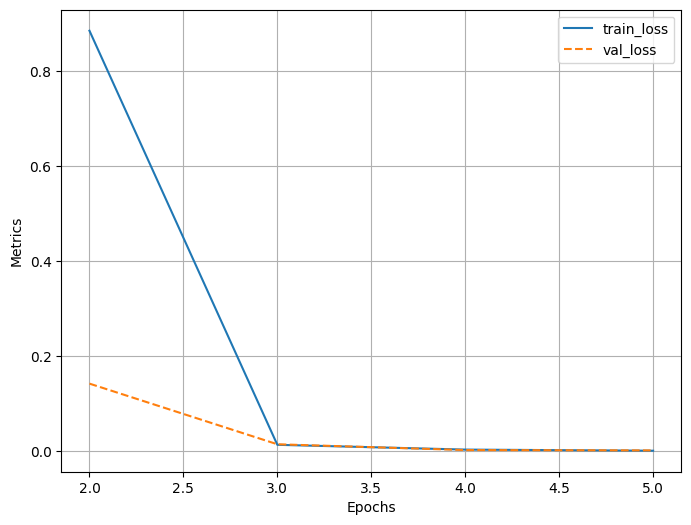

100%|██████████| 106/106 [00:00<00:00, 129393.55it/s]


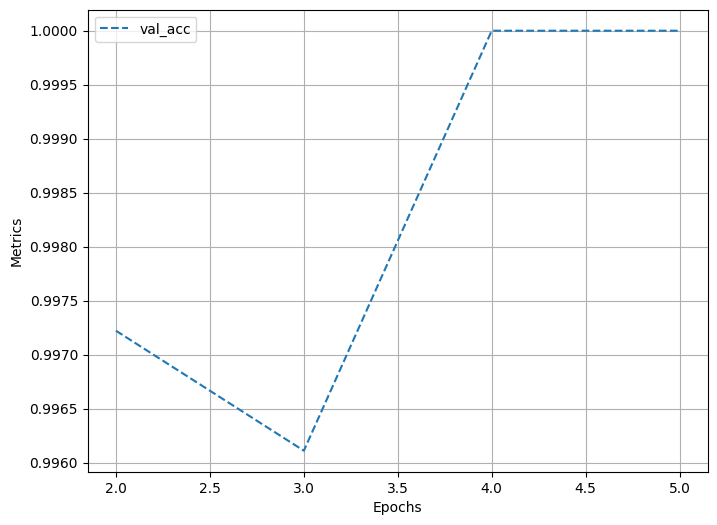

In [13]:
log.plot_epochs(['train_loss','val_loss'])
log.plot_epochs(['val_acc'])

### Evaluate the model

In [14]:
# load best model
del train_loader
del train_set
del val_loader
del val_set

test_set = FishDataloader(osp.join(dataset_dir, 'test'), transforms=val_transforms)
test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)

model = get_model()
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)

loss, acc = validate(model, test_loader, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.000826 Acc: 1.000000